# Random Walk - Comparing the prediction capabilities of TD(0) and constant-alpha MC

Ref: RL by Sutton, Barto, Chapter 6, Example 6.2, Pg. 125

# Import required libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gym
import gym_walk
from collections import defaultdict
from tqdm import tqdm

# Define Functions

## Function: policy

In [2]:
def policy(state, pol_ind):
    if (pol_ind == 1):
        action = np.random.choice([0, 1])
            
    return action

## Function: gen_episode

In [3]:
def gen_episode(env, policy, pol_ind):
    
    '''
    Generate one episode of agent-environment interaction
    Arguments:
        env: Instance of environment to use for generating episode
        policy: Policy to use for generating episode
        pol_ind: Index of policy to use for generating episode        
        
    Returns:
        states_list: List of states encountered in the episode (includes init_state and term_state)
        actions_list: List of actions take by agent at each time step
        rewards_list: List of rewards received by agent at each time step
    '''
    
    states_list = [] # Placeholder to store list of all states encountered in episode
    actions_list = [] # Placeholder to store list of all actions taken by agent
    rewards_list = [] # Placeholder to store list of rewards received at each step

    curr_state = env.reset() # Reset environment and obtain starting state
    while (True): # Run agent till terminal states are reached
        states_list.append(curr_state) # Update states_list with initial state    
        action = policy(curr_state, pol_ind) # Generate action according to current policy
        next_state, rew, done, _ = env.step(action) # Take action and obtain R, S'    
        actions_list.append(action) # Update actions_list
        rewards_list.append(rew) # Update rewards list
        curr_state = next_state
        # Stop episode if terminal state has been reached
        if (done): 
            break
            
    return states_list, actions_list, rewards_list      

## Function: mc_prediction

In [4]:
def mc_prediction(env, policy, pol_ind, num_ep, gamma, visit_type, init_value = 0.0):
    
    '''
    Function to run MC prediction and estimate state value function
    Arguments:
        env: Instance of environment to use for generating episode
        policy: Policy for which SVF has to be estimated
        pol_ind: Index of policy to use for generating episode
        num_ep: Number of episodes to use for MC prediction algorithm
        gamma: Discounting factor for reward computation
        visit_type: 'first' for first-visit MC prediction,
                    'every' for every-visit MC prediction.
        init_value: Value to initialize svf for all states
        
    Returns:
        svf_pi: State value function for policy pi
        state_count: Number of times each state is encountered during MC prediction
    '''
    
    # Initialize value function and count for all states to zero
    svf_pi = defaultdict(lambda: init_value) # State value function for given policy 'pi'
    state_count = defaultdict(int) # Number of times each state is encountered across episodes
    
    # Loop through 'num_ep' episodes
    for ep in range(num_ep):
        ep_states, ep_actions, ep_rewards = gen_episode(env, policy, pol_ind) # Generate one episode
        num_timesteps = len(ep_rewards) # Number of timesteps in current episode
        G = 0 # Initialize return to 0
        
        # Loop through each timestep of current episode
        for ind in range((num_timesteps - 1), -1, -1): 
            G = gamma * G + ep_rewards[ind] # Update return of current timestep
            curr_state = ep_states[ind] # Retrieve state of current timestep
            if (visit_type == 'first'): # For first-visit MC prediction
                if (curr_state not in ep_states[0:ind]):
                    state_count[curr_state] += 1
                    svf_pi[curr_state] += (G - svf_pi[curr_state]) / state_count[curr_state]
            elif (visit_type == 'every'): # For every-visit MC prediction
                state_count[curr_state] += 1
                svf_pi[curr_state] += (G - svf_pi[curr_state]) / state_count[curr_state]
                 
        
    return svf_pi, state_count

## Function: const_alpha_mc_prediction

In [5]:
def const_alpha_mc_prediction(env, policy, pol_ind, num_ep, alpha, gamma = 1.0, visit_type = 'every', init_dict = None):
    
    '''
    Function to run contant-alpha MC prediction and estimate state value function for a given policy
    Arguments:
        env: Instance of environment to use for constant-alpha MC prediction
        policy: Policy to evaluate
        pol_ind: Index of policy to use for generating episode
        num_ep: Number of episodes to use for const-alpha MC prediction algorithm
        alpha: Learning Rate
        gamma: Discounting factor for reward computation
        visit_type: 'first' for first-visit MC prediction,
                    'every' for every-visit MC prediction.
        init_dict: Dictionary based on which svf_pi will be initialized
        
    Returns:
        svf_pi: State-value function for policy pi
    '''
    
    svf_pi = defaultdict(int) # Dictionary to store state value function for given policy 'pi'
    if (init_dict != None):
        if (init_dict['val_init']): 
            for state in init_dict['state_list']:
                svf_pi[state] = init_dict['init_val']
    
    # Loop through 'num_ep' episodes
    for ep in range(num_ep):
        ep_states, ep_actions, ep_rewards = gen_episode(env, policy, pol_ind) # Generate one episode
        num_timesteps = len(ep_rewards) # Number of timesteps in current episode
        G = 0 # Initialize return to 0
        
        # Loop through each timestep of current episode
        for ind in range((num_timesteps - 1), -1, -1): 
            G = gamma * G + ep_rewards[ind] # Update return of current timestep
            curr_state = ep_states[ind] # Retrieve state of current timestep
            if (visit_type == 'first'): # For first-visit MC prediction
                if (curr_state not in ep_states[0:ind]):
                    svf_pi[curr_state] += alpha * (G - svf_pi[curr_state])
            elif (visit_type == 'every'): # For every-visit MC prediction
                svf_pi[curr_state] += alpha * (G - svf_pi[curr_state])
        
    return svf_pi

## Function: td0_prediction

In [6]:
def td0_prediction(env, policy, pol_ind, num_ep, gamma = 1.0, alpha = 0.5, init_dict = None):
    
    """
    Tabular TD(0) algorithm.
    Ref: Section 6.1, Pg. 120 of RL_Sutton
    
    Arguments:
        env: Instance of environment to use for constant-alpha MC prediction
        policy: Policy to evaluate
        pol_ind: Index of policy to use for generating episode
        num_ep: Number of episodes to use for TD(0) prediction algorithm
        gamma: Discounting factor for reward computation
        alpha: Learning Rate       
        init_dict: Dictionary based on which svf_pi will be initialized
        
    Returns:
        svf_pi: State-value function for policy pi    
    
    """
    
    svf_pi = defaultdict(int) # Dictionary to store state value function for given policy 'pi'
    if (init_dict != None):
        if (init_dict['val_init']): 
            for state in init_dict['state_list']:
                svf_pi[state] = init_dict['init_val']

    for ep in range(num_ep): # Iterate through num_ep
        curr_state = env.reset() # Reset environment and obtain starting state
        while (True):
            action = policy(curr_state, pol_ind) # Generate action according to current policy
            next_state, rew, done, _ = env.step(action) # Take action and obtain R, S' 

            # Perform TD(0) update
            td_target = rew + gamma * svf_pi[next_state]
            td_delta = td_target - svf_pi[curr_state]
            svf_pi[curr_state] += alpha * td_delta
            curr_state = next_state # S <-- S'

            if (done):
                break   
    
    return svf_pi

# SVF prediction using MC Prediction

In [7]:
# Instantiate Environment
env = gym.make('WalkFive-v0')

# Define true value function
tvf = (1/6) * np.arange(1, 6, 1)

ep_count_arr = [25, 50, 75, 100, 1000, 10000, 100000]
rmse_dict = dict()

# Obtain RMSE vs. #episodes
for ep_count in tqdm(ep_count_arr):
    svf, _ = mc_prediction(env, policy, 1, ep_count, 1, 'first') # Run MC prediction
    svf = np.array(sorted(list(svf.values()))) # Convert svf to array
    rmse = np.sqrt(np.mean((tvf - svf) ** 2)) # Compute RMSE
    rmse_dict[ep_count] = rmse
    
for key, value in rmse_dict.items():
    print(key,':','%1.2e' %value) # Print RMSE across episodes

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:44<00:00,  6.37s/it]

25 : 8.49e-02
50 : 5.99e-02
75 : 2.78e-02
100 : 6.58e-02
1000 : 8.16e-03
10000 : 5.88e-03
100000 : 2.30e-03


# SVF prediction using Const-alpha MC Prediction

In [8]:
# Instantiate Environment
env = gym.make('WalkFive-v0')

# Define true value function
tvf = (1/6) * np.arange(1, 6, 1)

alpha = 0.01
ep_count_arr = [25, 50, 75, 100, 1000, 10000, 100000]
rmse_dict = dict()

# Obtain RMSE vs. #episodes
for ep_count in tqdm(ep_count_arr):
    svf = const_alpha_mc_prediction(env, policy, 1, ep_count, alpha, 1, 'first') # Run MC prediction
    svf = np.array(sorted(list(svf.values()))) # Convert svf to array
    rmse = np.sqrt(np.mean((tvf - svf) ** 2)) # Compute RMSE
    rmse_dict[ep_count] = rmse
    
for key, value in rmse_dict.items():
    print(key,':','%1.2e' %value) # Print RMSE across episodes

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:41<00:00,  5.98s/it]

25 : 4.43e-01
50 : 3.52e-01
75 : 2.91e-01
100 : 2.97e-01
1000 : 2.72e-02
10000 : 3.88e-02
100000 : 2.18e-02


**From the results above, we can see that regular MC-prediction is able to achieve lower RMSE for the same number of episodes as compared to constant-alpha MC**

# SVF prediction using TD(0) Prediction

In [12]:
# Instantiate Environment
env = gym.make('WalkFive-v0')

# Define true value function
tvf = (1/6) * np.arange(1, 6, 1)

alpha = 0.1
ep_count_arr = [25, 50, 75, 100, 1000, 10000, 100000]
rmse_dict = dict()

# Dictionary to initialize svf
init_dict = {"val_init": True,
             "state_list": [1, 2, 3, 4, 5],
             "init_val": 0.5
            }

# Obtain RMSE vs. #episodes
for ep_count in tqdm(ep_count_arr):
    svf = td0_prediction(env, policy, 1, ep_count, gamma = 1, alpha = alpha, init_dict = init_dict) # Run TD(0) prediction
    if (0 in svf.keys()):
        del svf[0]
    if (6 in svf.keys()):
        del svf[6]       
    svf = np.array(sorted(list(svf.values()))) # Convert svf to array
    rmse = np.sqrt(np.mean((tvf - svf) ** 2)) # Compute RMSE
    rmse_dict[ep_count] = rmse
    
for key, value in rmse_dict.items():
    print(key,':','%1.2e' %value) # Print RMSE across episodes

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:44<00:00,  6.31s/it]

25 : 3.62e-02
50 : 3.71e-02
75 : 4.19e-02
100 : 3.11e-02
1000 : 3.53e-02
10000 : 3.00e-02
100000 : 3.73e-02


# Example 6.2 - Random Walk - Part A

Plot learnt value function vs. true value fuction for TD(0) (alpha = 0.1) for different episode lengths

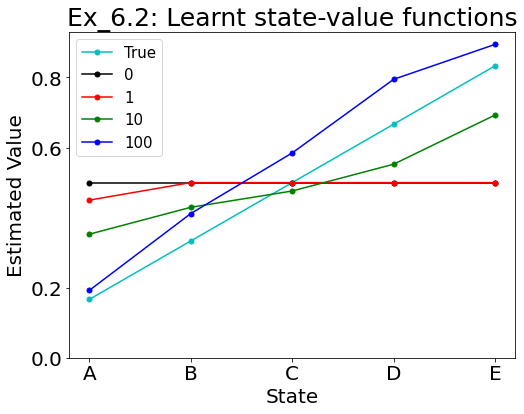

In [10]:
num_ep_list = [0, 1, 10, 100] # Number of episodes in each run
color_list = ['k', 'r', 'g', 'b']

# Define true value function
tvf = (1/6) * np.arange(1, 6, 1)

# Dictionary to initialize svf
init_dict = {"val_init": True,
             "state_list": [1, 2, 3, 4, 5],
             "init_val": 0.5
            }
alpha = 0.1

plt.figure(figsize = (8, 6))
plt.plot(tvf, color = 'c', label = 'True', marker = '.', ms = 10.0)

for ind, num_ep in enumerate(num_ep_list): # Iterate through num_ep_list
    # Run TD(0) algorithm
    svf = td0_prediction(env, policy, 1, num_ep, gamma = 1.0, alpha = alpha, init_dict = init_dict)
    if (0 in svf.keys()):
        del svf[0]
    if (6 in svf.keys()):
        del svf[6]       
    svf = np.array(sorted(list(svf.values()))) # Convert svf to array
    plt.plot(svf, label = str(num_ep), color = color_list[ind], marker = '.', ms = 10.0)

plt.title("Ex_6.2: Learnt state-value functions", fontsize = 25)
plt.xlabel("State", fontsize = 20)
plt.ylabel("Estimated Value", fontsize = 20)
plt.xticks(ticks = [0, 1, 2, 3, 4], labels = ['A', 'B', 'C', 'D', 'E'], fontsize = 20)
plt.yticks(ticks = [0, 0.2, 0.6, 0.8], fontsize = 20)
plt.legend(fontsize = 15)
plt.show()

**The graph above shows the values learnt after episodes of various lengths on a single run of TD(0). The estimates after 100 episodes are about as close as they ever come to the true values - with a constant step-size parameter (alpha = 0.1)**

# Example 6.2 - Random Walk - Part B

Empirical RMSE vs. number of episodes for TD(0) and constant-alpha MC

100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [01:33<00:00,  1.83s/it]


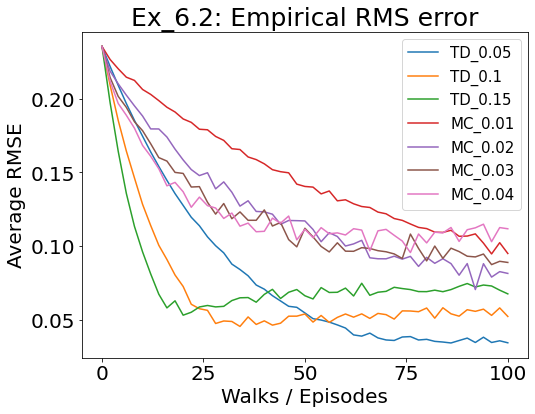

In [11]:
num_states = 7 # Number of states in random walk (2 terminal states)
num_runs = 100 # Number of runs to average over
ep_max = 101
ep_step = 2

# Define true value function
tvf = (1/6) * np.arange(1, 6, 1)

# Dictionary to initialize svf
init_dict = {"val_init": True,
             "state_list": [1, 2, 3, 4, 5],
             "init_val": 0.5
            }

plt.figure(figsize = (8, 6))
plt.title("Ex_6.2: Empirical RMS error", fontsize = 25)
plt.xlabel("Walks / Episodes", fontsize = 20)
plt.ylabel("Average RMSE", fontsize = 20)
plt.xticks(ticks = [0, 25, 50, 75, 100], fontsize = 20)
plt.yticks(ticks = [0, 0.05, 0.1, 0.15, 0.2, 0.25], fontsize = 20)

alpha_array_td = [0.05, 0.1, 0.15] # List of alpha values to use for TD(0)
for alpha in alpha_array_td: # Iterate through each alpha value
    rmse_td_array = [] # Placeholder to store average rmse for different episode lengths
    num_ep_array = [] # Placeholder to store  episode lengths
    for num_ep in tqdm(range(0, ep_max, ep_step)): # Loop through different episode lengths
        rmse_td = 0
        for run in range(num_runs): # Iterate through num_runs
            # Run TD(0) algorithm            
            svf_td = td0_prediction(env, policy, 1, num_ep, gamma = 1.0, alpha = alpha, init_dict = init_dict)
            if (0 in svf_td.keys()):
                del svf_td[0]
            if (6 in svf_td.keys()):
                del svf_td[6]   
            svf_td = np.array(sorted(list(svf_td.values()))) # Convert svf to array
            rmse_td += np.sqrt(np.mean((tvf - svf_td) ** 2)) # Update rmse with current run
        rmse_td /= num_runs # Average rmse over all runs
        rmse_td_array.append(rmse_td)
        num_ep_array.append(num_ep)
    plt.plot(num_ep_array, rmse_td_array, label = ('TD_' + str(alpha)))


alpha_array_mc = [0.01, 0.02, 0.03, 0.04] # List of alpha values to use for constant-alpha MC
for alpha in alpha_array_mc: # Iterate through each alpha value
    rmse_mc_array = [] # Placeholder to store average rmse for different episode lengths
    num_ep_array = [] # Placeholder to store  episode lengths
    for num_ep in tqdm(range(0, ep_max, ep_step)): # Loop through different episode lengths
        rmse_mc = 0
        for run in range(num_runs): # Iterate through num_runs
            # Run Const-alpha MC algorithm
            svf_mc = const_alpha_mc_prediction(env, policy, 1, num_ep, alpha, 1.0, visit_type = 'every',\
                                               init_dict = init_dict)
            svf_mc = np.array(sorted(list(svf_mc.values()))) # Convert svf to array            
            rmse_mc += np.sqrt(np.mean((tvf - svf_mc) ** 2))
        rmse_mc /= num_runs
        rmse_mc_array.append(rmse_mc)
        num_ep_array.append(num_ep)    
    plt.plot(num_ep_array, rmse_mc_array, label = ('MC_' + str(alpha)))

plt.legend(fontsize = 15)
plt.show()

**The graph above shows learning curves for the two methods (constant-alpha MC and TD(0)) for various values of alpha. The perfomance measure shown is the RMS error between the learnt value function and the true value function, averaged over the five states, then averaged over 100 runs.**


**In all cases, the approximate value function was initialized to the intermediate value V(s) = 0.5, for all states. As can be seen from the plots, the TD method is consistently better than the MC method on this task.**